In [1]:
# https://www.kaggle.com/uciml/iris?select=Iris.csv

In [2]:
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

from sklearn.neighbors import LocalOutlierFactor

from lightgbm import LGBMClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.style.use('seaborn-deep')
sns.set()


%matplotlib inline

%config InlineBackend.figure_format = 'retina'

In [47]:
data = pd.read_csv('Iris.csv')

In [48]:
data.head(3)

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa


In [49]:
data = data.drop('Id', axis=1)

## Help functions

In [50]:
def std_outliers_plot(df, feature, threshold=3):
    '''This function colculate std outlires and plot this
        
        threshold = 3 - 99.7 %
        threshold = 2 - 95 %
        threshold = 1 - 68 %
        
    '''
    mean, std = np.mean(df), np.std(df)
    z_score = np.abs((df-mean) / std)
    good = z_score < threshold   
    
    print(f'std: threshold = {threshold}\n')
    print(f"Rejection: {(~good).sum()} points\nPercentage of outliers: {round((~good).sum() * 100 / df.size, 4)} %")
    
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    
    return good

def lof_outliers_plot(df, feature, threshold=0.5):
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.001, p=1)
    good = lof.fit_predict(df) > threshold
    
    print(f'lof: threshold = {threshold}\n')
    print(f"Rejection {(~good).sum()} points\nPercentage of outliers: {round((~good).sum() * 100 / df.size, 4)} %")
    
    visual_scatter = np.random.normal(size=df.size)
    plt.scatter(df[good], visual_scatter[good], s=2, label="Good", color="#4CAF50")
    plt.scatter(df[~good], visual_scatter[~good], s=8, label="Bad", color="#F44336")
    plt.legend(loc='upper right')
    plt.title(feature)
    plt.show();
    
    return good
    

## Analysis data

In [51]:
data.head(2)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa


<AxesSubplot:>

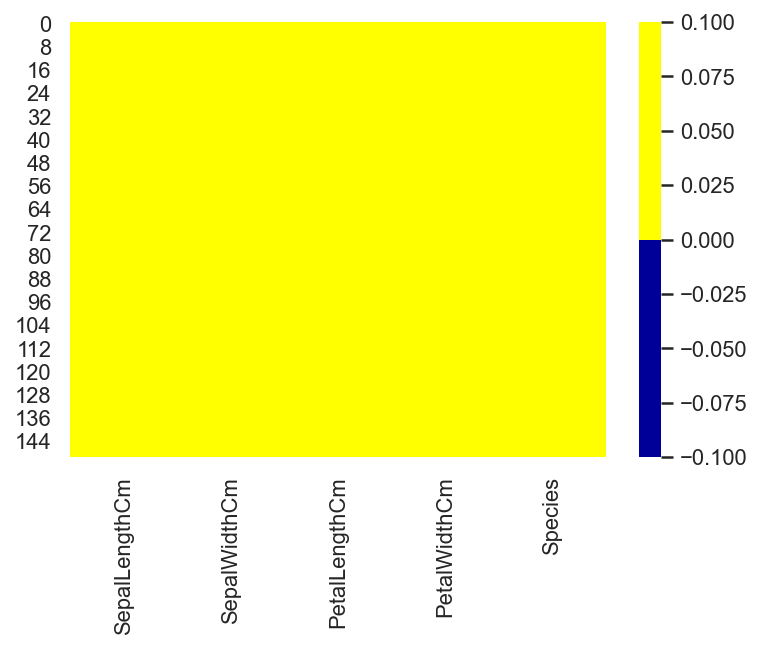

In [52]:
colours = ['#000099', '#ffff00'] 
sns.heatmap(data.isnull(), cmap=colours)

<AxesSubplot:>

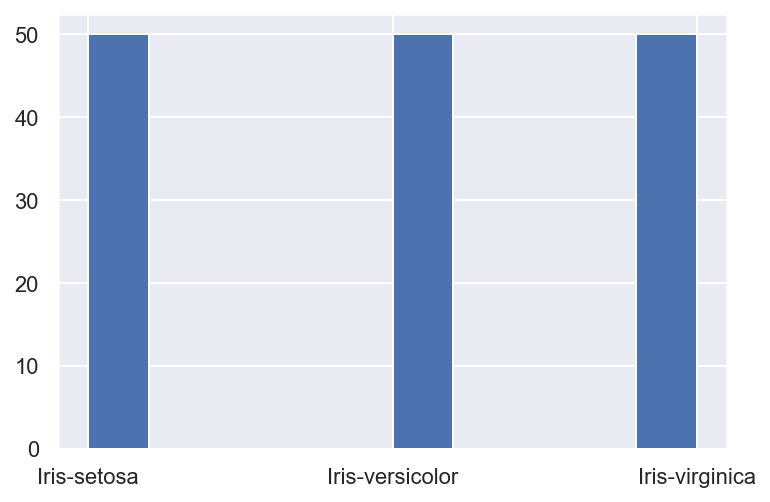

In [53]:
data['Species'].hist()

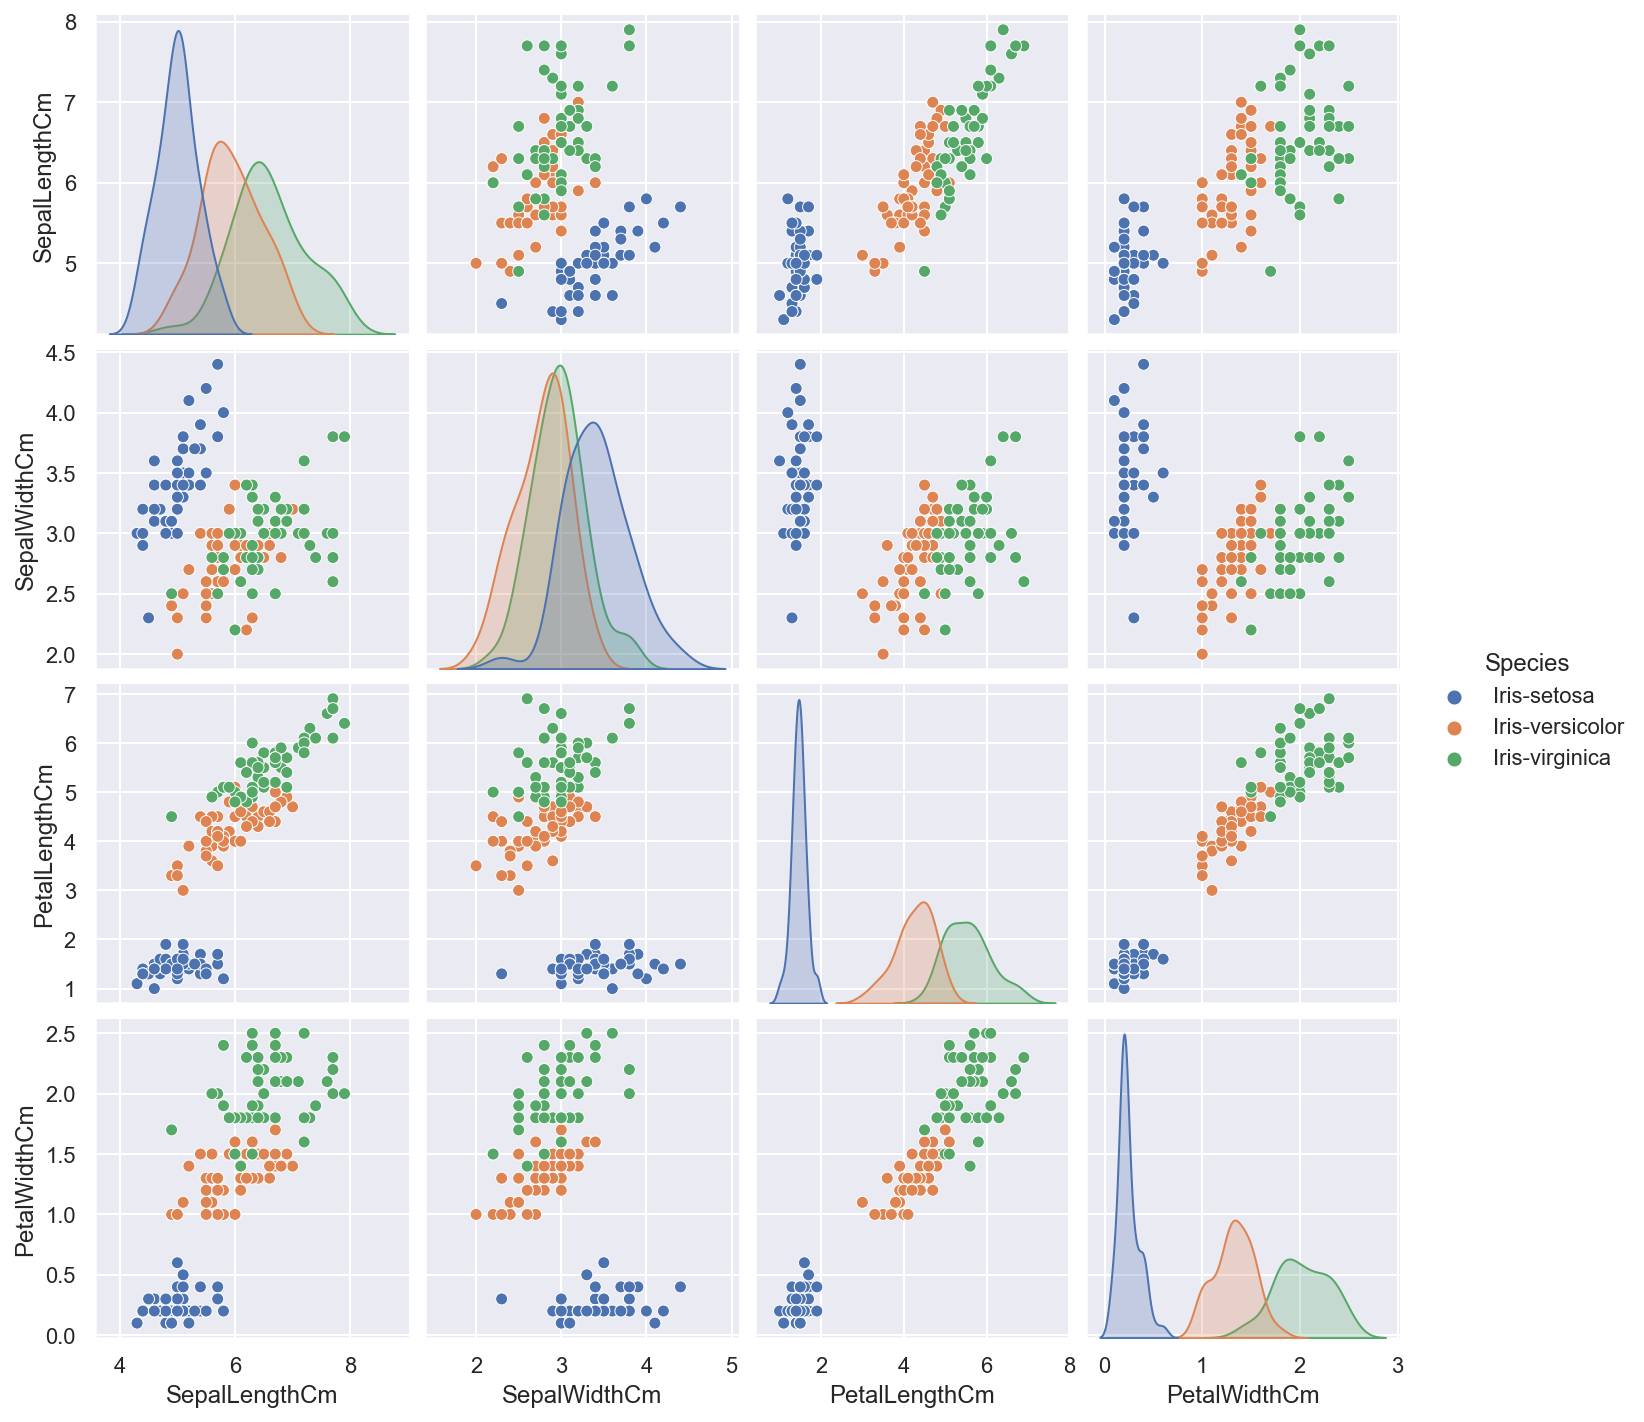

In [54]:
sns.pairplot(data, hue='Species',)

<AxesSubplot:>

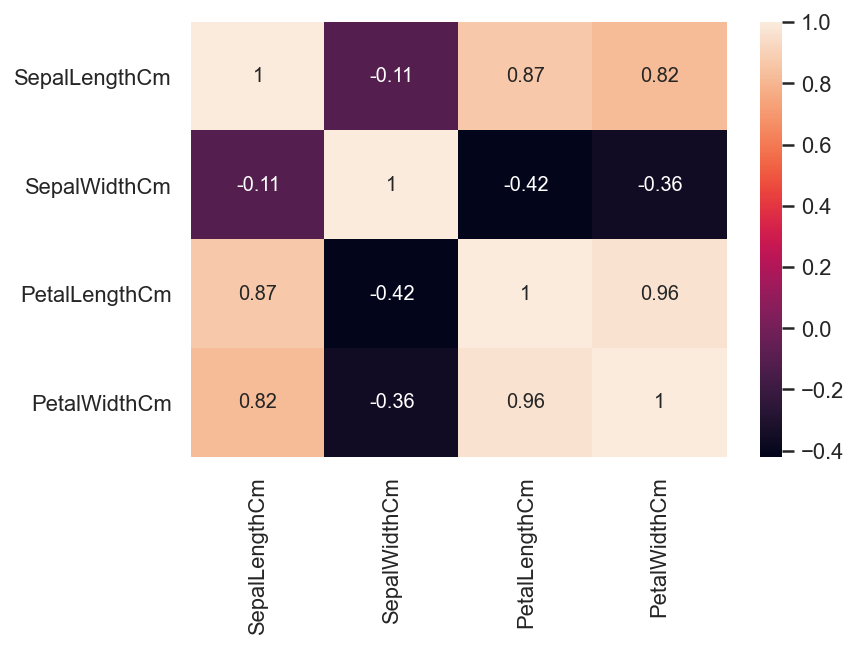

In [55]:
sns.heatmap(data.corr(), annot=True)

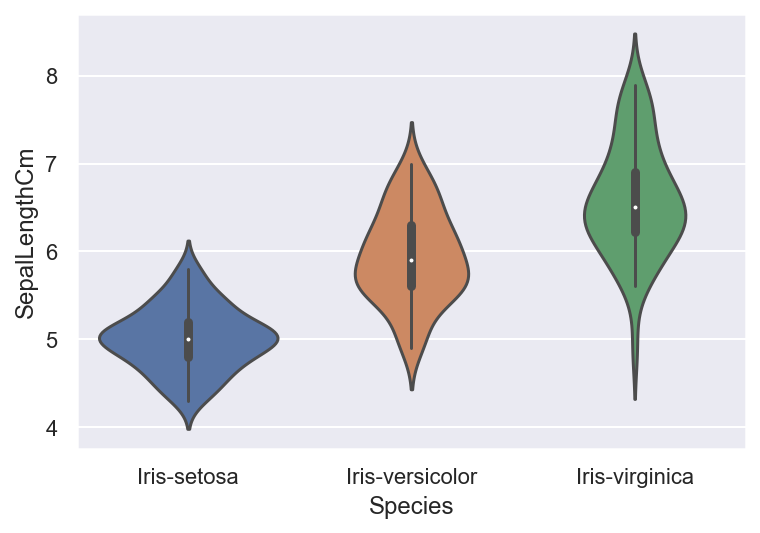

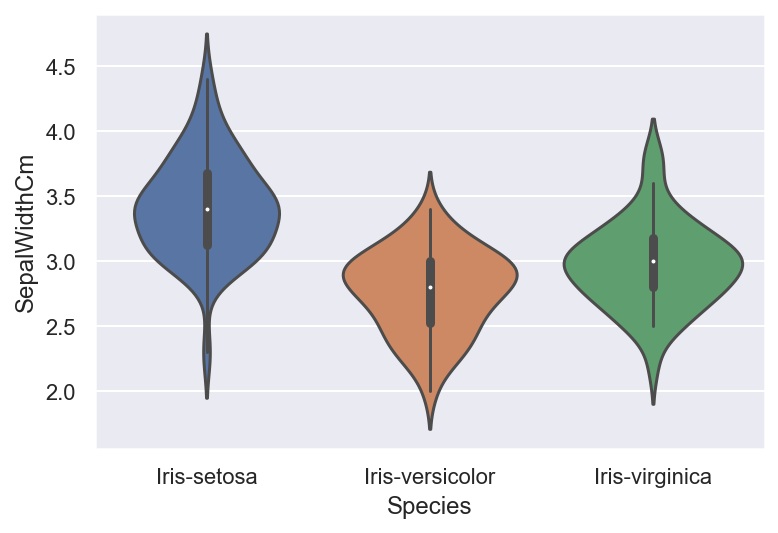

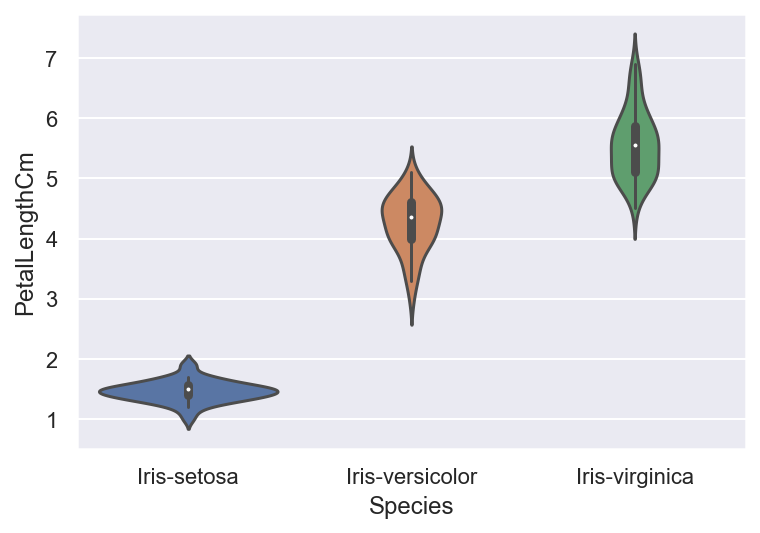

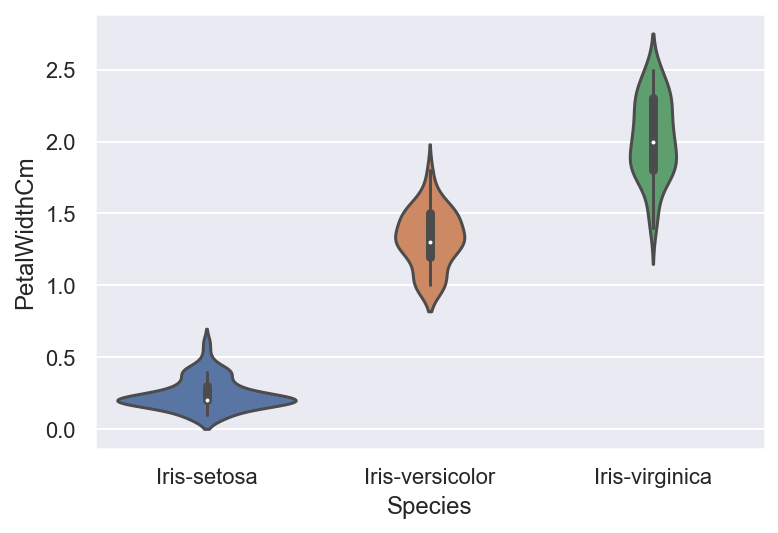

In [56]:
for col in data.drop('Species', axis=1).columns.tolist():
    sns.violinplot(x='Species', y=col, data=data,)
    plt.show()

SepalLengthCm
############################################
std: threshold = 3

Rejection: 0 points
Percentage of outliers: 0.0 %


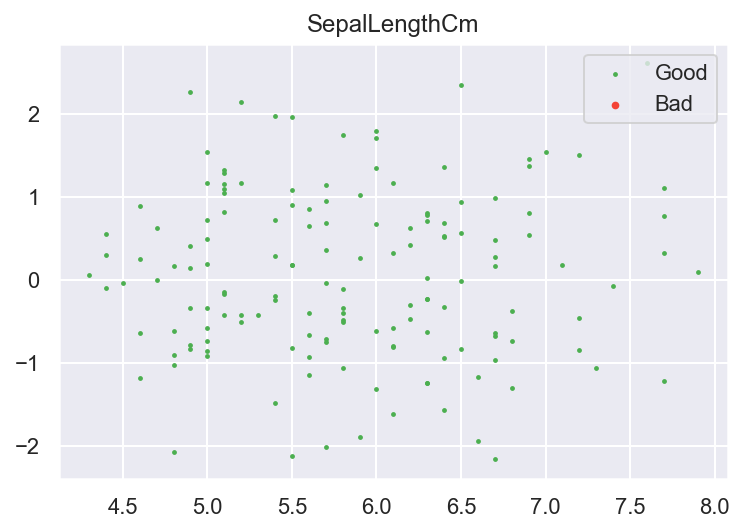

std: threshold = 2

Rejection: 6 points
Percentage of outliers: 4.0 %


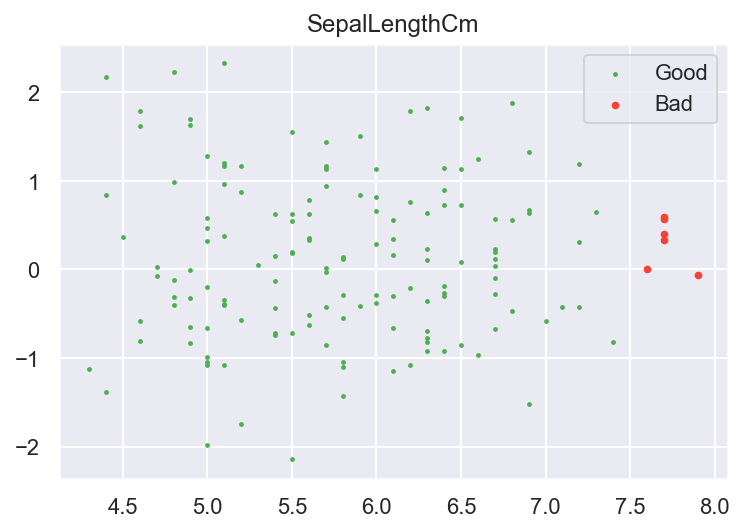

lof: threshold = 0.5

Rejection 1 points
Percentage of outliers: 0.6667 %


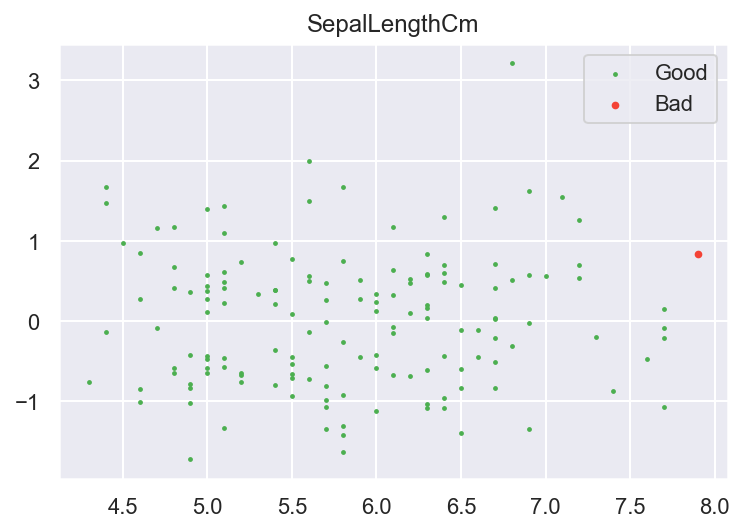

SepalWidthCm
############################################
std: threshold = 3

Rejection: 1 points
Percentage of outliers: 0.6667 %


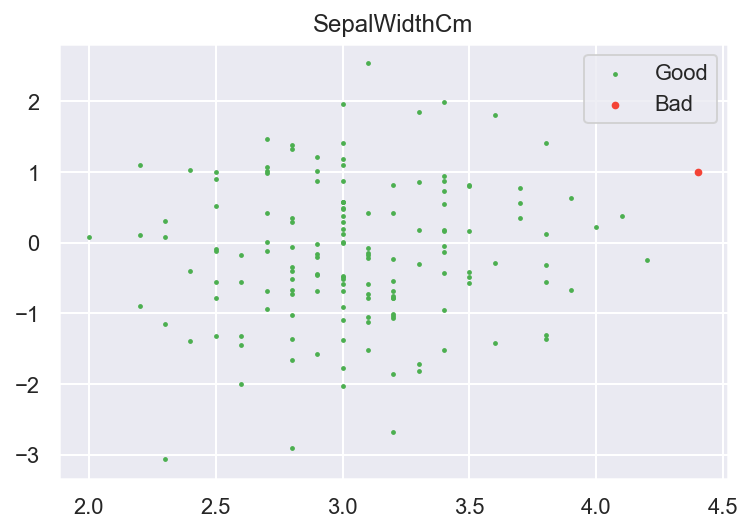

std: threshold = 2

Rejection: 5 points
Percentage of outliers: 3.3333 %


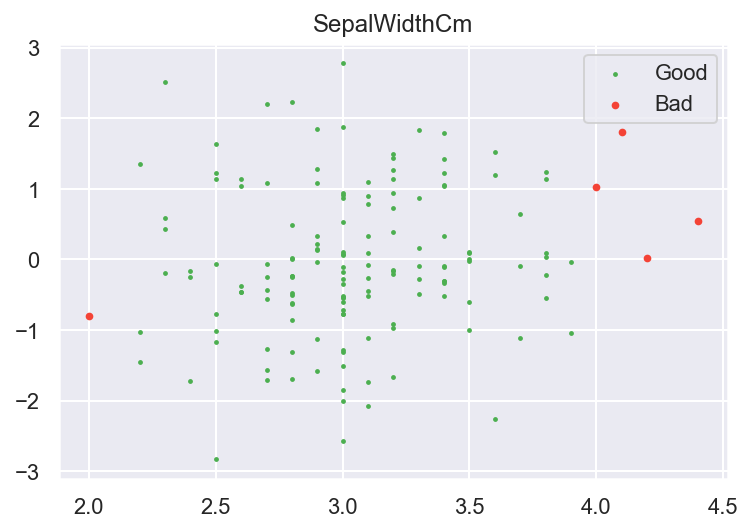

lof: threshold = 0.5

Rejection 0 points
Percentage of outliers: 0.0 %


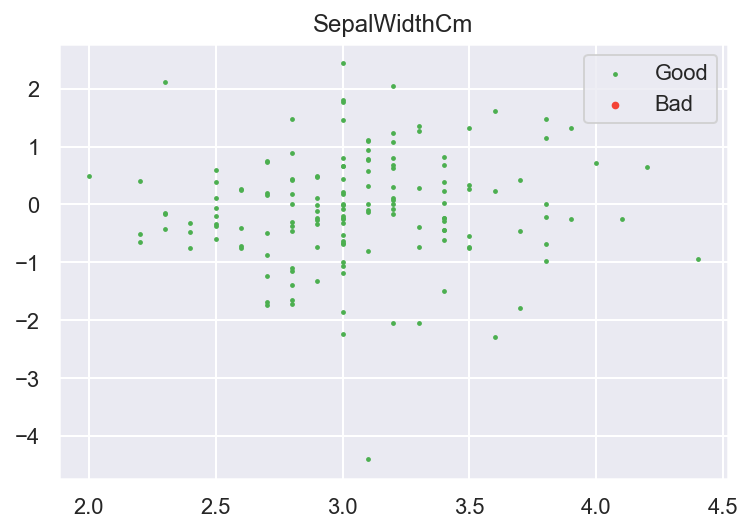

PetalLengthCm
############################################
std: threshold = 3

Rejection: 0 points
Percentage of outliers: 0.0 %


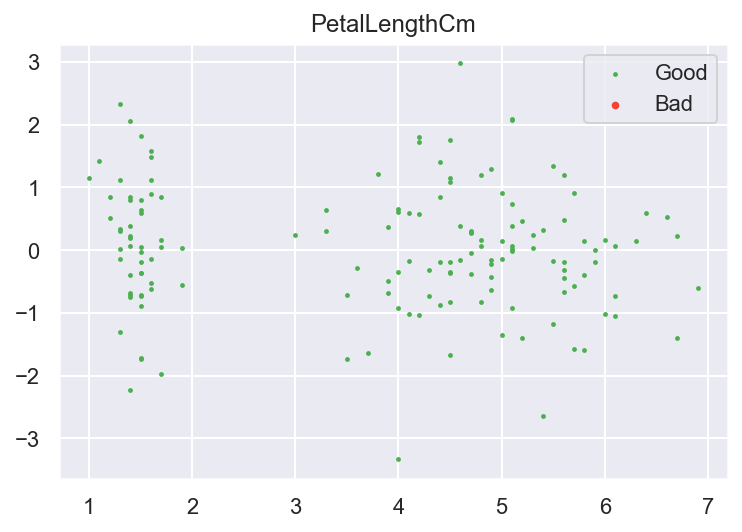

std: threshold = 2

Rejection: 0 points
Percentage of outliers: 0.0 %


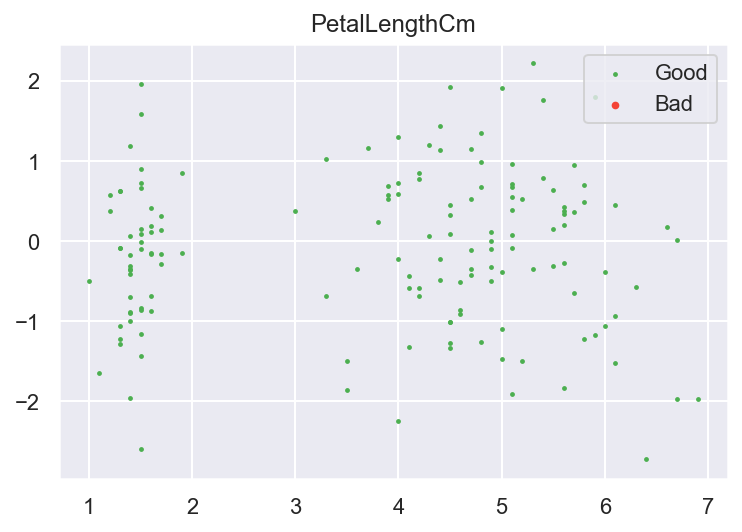

lof: threshold = 0.5

Rejection 1 points
Percentage of outliers: 0.6667 %


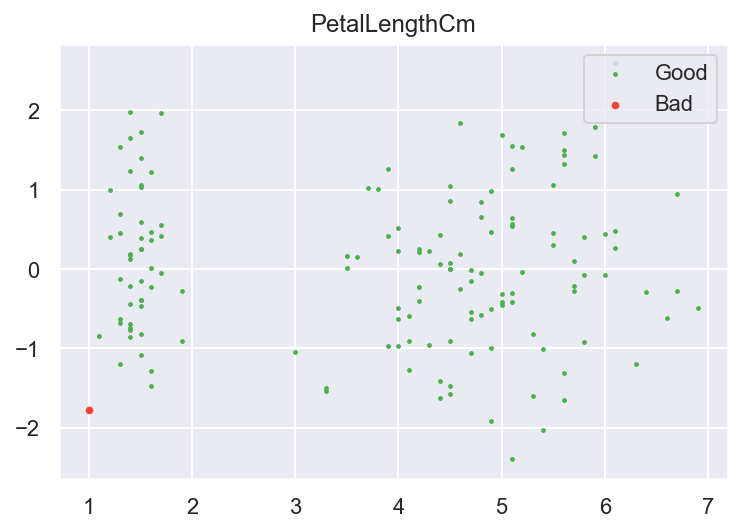

PetalWidthCm
############################################
std: threshold = 3

Rejection: 0 points
Percentage of outliers: 0.0 %


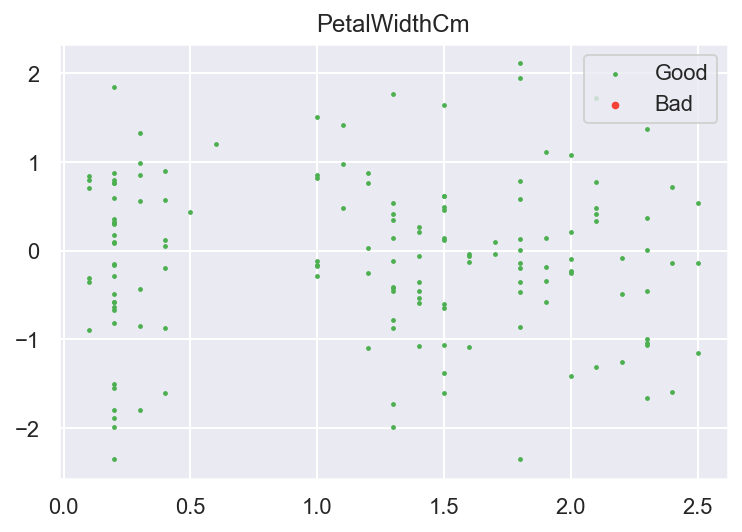

std: threshold = 2

Rejection: 0 points
Percentage of outliers: 0.0 %


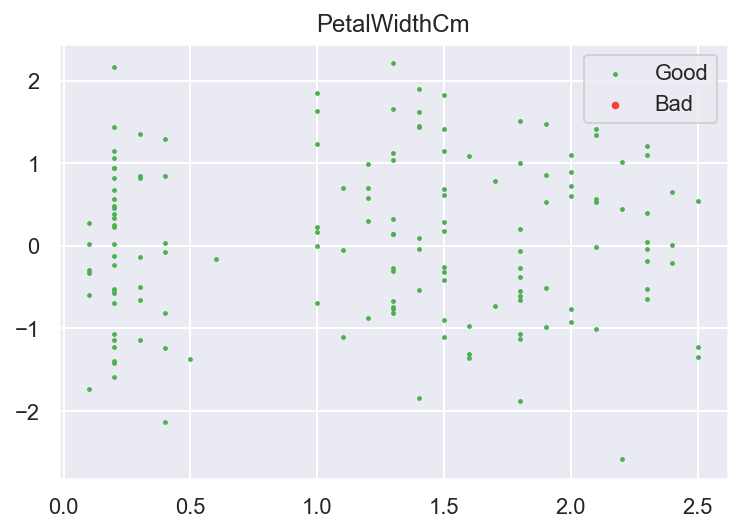

lof: threshold = 0.5

Rejection 0 points
Percentage of outliers: 0.0 %


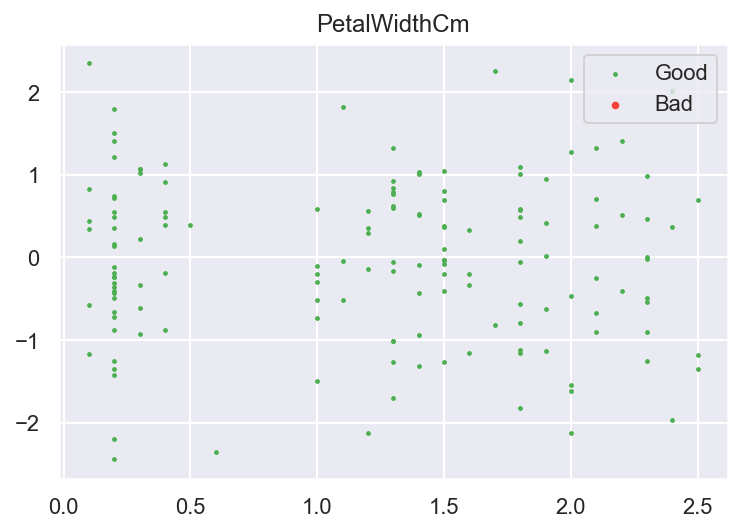

Species
############################################
std: threshold = 3

Rejection: 0 points
Percentage of outliers: 0.0 %


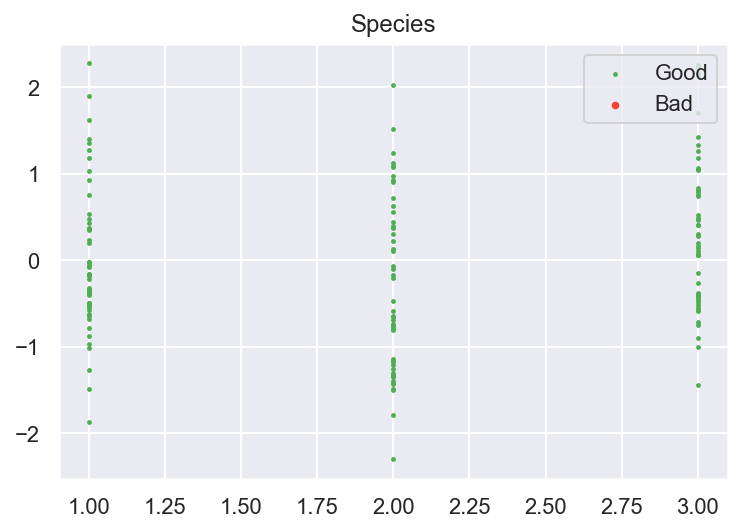

std: threshold = 2

Rejection: 0 points
Percentage of outliers: 0.0 %


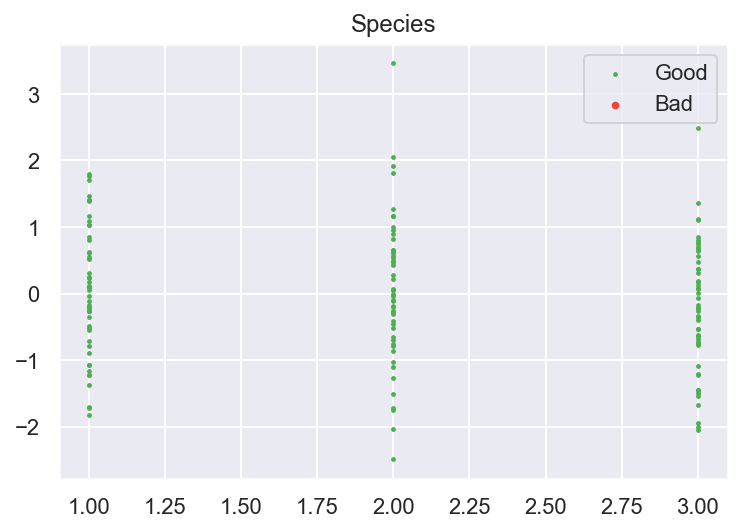

lof: threshold = 0.5

Rejection 0 points
Percentage of outliers: 0.0 %


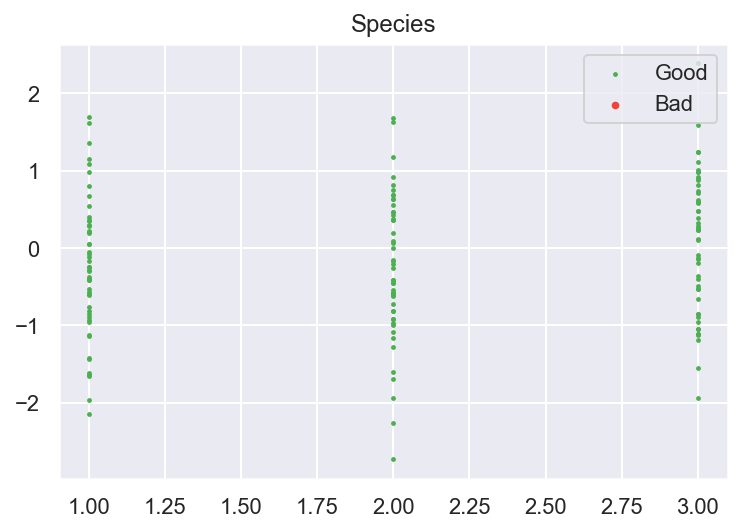

In [57]:
data['Species'] = data['Species'].map({'Iris-setosa': 1,
                                       'Iris-virginica': 2,
                                       'Iris-versicolor': 3})

for col in data.columns:
    print(col)
    print('############################################')
    std_target_outsliers = std_outliers_plot(data[col], col)
    std_target_outliers = std_outliers_plot(data[col], col, threshold=2)
    lof_target_outliers = lof_outliers_plot(data[col].values.reshape(data[col].shape[0], -1), col)

std: threshold = 3

Rejection: 0 points
Percentage of outliers: 0.0 %


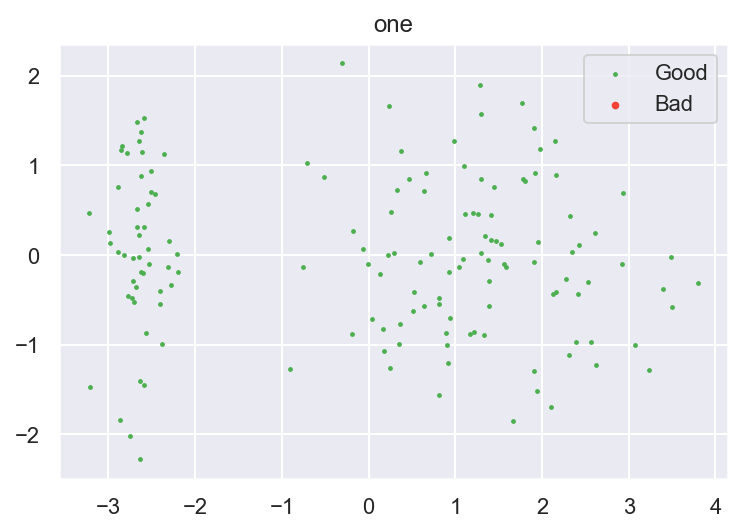

std: threshold = 2

Rejection: 0 points
Percentage of outliers: 0.0 %


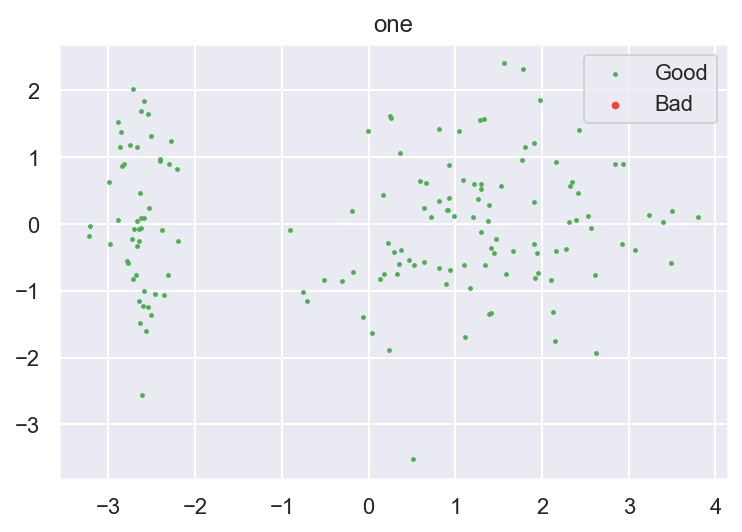

lof: threshold = 0.5

Rejection 1 points
Percentage of outliers: 0.6667 %


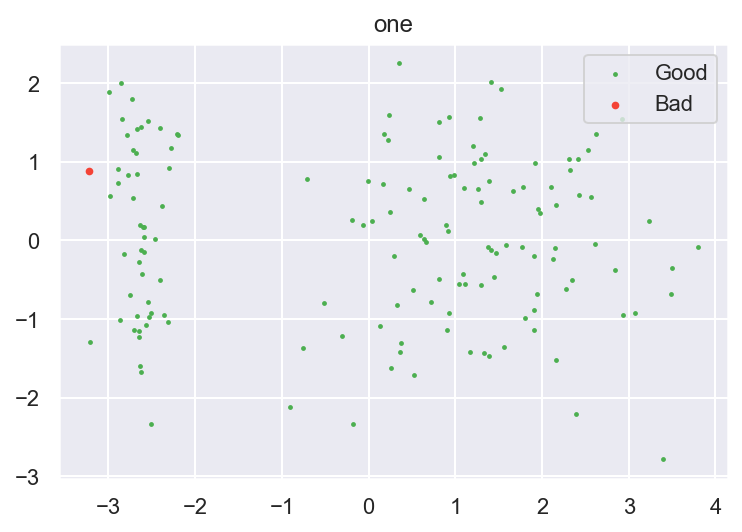

In [58]:
pca = PCA(n_components=1)
XX = pd.DataFrame(pca.fit_transform(data.drop('Species', axis=1)), columns=['one'])

std_target_outliers = std_outliers_plot(XX['one'], 'one')
std_target_outliers = std_outliers_plot(XX['one'], 'one', threshold=2)
lof_target_outliers = lof_outliers_plot(XX['one'].values.reshape(XX['one'].shape[0], -1), 'one')

## Predict Species

In [59]:
data['Species'].value_counts()

3    50
2    50
1    50
Name: Species, dtype: int64

In [60]:
X = data.drop('Species', axis=1)
y = data['Species']

In [61]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [62]:
lgbm = LGBMClassifier()
lgbm.fit(x_train, y_train)
accuracy_score(lgbm.predict(x_test), y_test,)

1.0

In [63]:
cross_val_score(lgbm, X, y, cv=10, scoring='accuracy').mean()

0.9533333333333334

<AxesSubplot:>

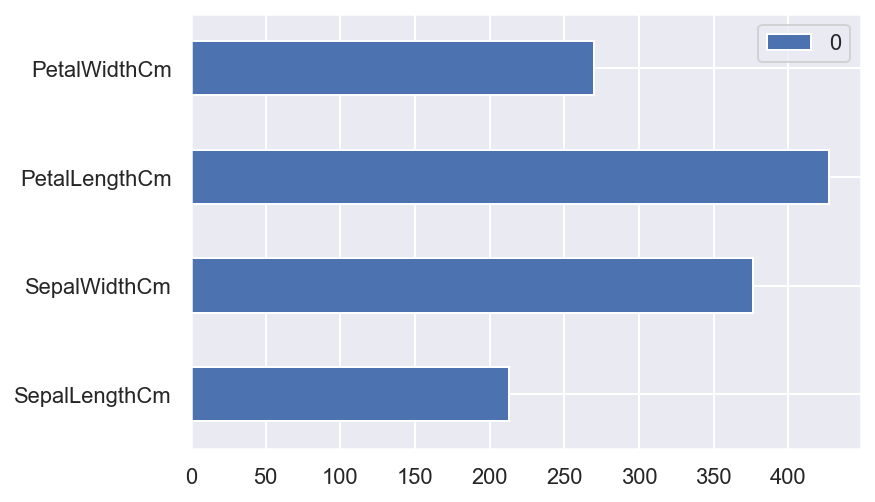

In [65]:
feat_importance_cross = pd.DataFrame(lgbm.feature_importances_, index=lgbm.feature_name_)
feat_importance_cross.plot(kind='barh')